In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
from matplotlib.patches import Circle
import matplotlib.animation as animation
import warnings
warnings.filterwarnings('ignore')


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
def load_simulation_data():
    """Load the simulated eye movement dataset"""
    data_path = 'data/train_data.pt'
    data = torch.load(data_path)
    
    print("Dataset Overview:")
    print(f"Data Keys: {list(data.keys())}")
    print(f"Visual Frames: {data['frames'].shape}")
    
    # Check for different key names (single fixation vs baseline)
    if 'durations' in data:
        print(f"Duration Sequences: {data['durations'].shape}")
        print(f"Fixation Coordinates: {data['coordinates'].shape}")
        print(f"Total Sequences: {data['frames'].shape[0]:,}")
    else:
        print("NOTE: This appears to be single fixation data (no duration sequences)")
        print(f"Coordinates: {data['coordinates'].shape}")
        print(f"Total Sequences: {data['frames'].shape[0]:,}")
    
    return data



In [3]:
sim_data = load_simulation_data()

Dataset Overview:
Data Keys: ['frames', 'coordinates', 'fixation_mask', 'metadata']
Visual Frames: torch.Size([1000, 1, 32, 32, 32])
NOTE: This appears to be single fixation data (no duration sequences)
Coordinates: torch.Size([1000, 32, 2])
Total Sequences: 1,000


In [4]:
def display_simulation_parameters(data):
    """Display simulation parameters"""
    metadata = data['metadata']
    
    print(f"\nSimulation Parameters:")
    print(f"Image Size: {metadata['img_size']} × {metadata['img_size']} pixels")
    print(f"Spatial Displacement σ: {metadata['sigma']:.1f}")
    print(f"Sequence Length: {data['frames'].shape[2]} frames")
    
    # Check if duration parameters exist (baseline vs single fixation)
    if 'ex_gaussian_mu' in metadata:
        print(f"\nDuration Distribution (Ex-Gaussian):")
        print(f"   μ (Normal Mean): {metadata['ex_gaussian_mu']}")
        print(f"   σ (Normal Std): {metadata['ex_gaussian_sigma']}")
        print(f"   τ (Exponential Scale): {metadata['ex_gaussian_tau']}")
        print(f"   Max Cap: {metadata['max_cap']} frames")
        
        # Quality metrics for baseline data
        if 'fixation_durations' in data:
            all_durations = []
            for batch in data['fixation_durations']:
                all_durations.extend(batch)
            
            mean_dur = np.mean(all_durations)
            max_dur = np.max(all_durations)
            
            print(f"\nQuality Validation:")
            print(f"   Mean Duration: {mean_dur:.2f} frames")
            print(f"   Max Duration: {max_dur} frames")
            print(f"   Max ≤ Cap: {max_dur <= metadata['max_cap']}")
            print(f"   Max ≤ 3×Mean: {max_dur <= 3*mean_dur}")
    else:
        print(f"\nSingle Fixation Mode:")
        print(f"   Each frame contains exactly one fixation")
        print(f"   No duration modeling (frame-by-frame fixations)")


In [5]:
display_simulation_parameters(sim_data)


Simulation Parameters:
Image Size: 32 × 32 pixels
Spatial Displacement σ: 4.5
Sequence Length: 32 frames

Single Fixation Mode:
   Each frame contains exactly one fixation
   No duration modeling (frame-by-frame fixations)


In [16]:

def analyze_spatial_distribution(data):
    """Analyze the spatial distribution of fixation locations"""
    
    # Extract coordinates
    sample_size = min(1000, data['coordinates'].shape[0])
    coords = data['coordinates'][:sample_size]  # Shape: (sample_size, T, 2)
    
    # For single fixation data, every frame has a fixation

    # Single fixation data - every frame is a fixation
    fixation_coords = []
    for b in range(sample_size):
        for t in range(coords.shape[1]):
            x, y = coords[b, t]
            fixation_coords.append([x.item(), y.item()])
    
    fixation_coords = np.array(fixation_coords)
    
    # Create spatial analysis plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Spatial Distribution of Fixation Locations', fontsize=14, fontweight='bold')
    
    img_size = data['metadata']['img_size']
    
    # 2D scatter plot of all fixations
    ax1.scatter(fixation_coords[:, 0], fixation_coords[:, 1], 
               alpha=0.1, s=15, c='blue', linewidth=0)
    ax1.set_xlim(0, img_size)
    ax1.set_ylim(0, img_size)
    ax1.set_xlabel('X Coordinate (pixels)')
    ax1.set_ylabel('Y Coordinate (pixels)')
    ax1.set_title(f'Fixation Locations ({len(fixation_coords)} fixations)')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # 2D density heatmap
    heatmap, xedges, yedges = np.histogram2d(fixation_coords[:, 0], fixation_coords[:, 1], 
                                           bins=16, range=[[0, img_size], [0, img_size]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax2.imshow(heatmap.T, extent=extent, origin='lower', cmap='YlOrRd', alpha=0.8)
    ax2.set_xlabel('X Coordinate (pixels)')
    ax2.set_ylabel('Y Coordinate (pixels)')
    ax2.set_title('Fixation Density Heatmap')
    plt.colorbar(im, ax=ax2, label='Fixation Count')
    
    # X coordinate distribution
    ax3.hist(fixation_coords[:, 0], bins=20, alpha=0.7, edgecolor='black', density=True)
    ax3.axvline(fixation_coords[:, 0].mean(), color='red', linestyle='--', 
               label=f'Mean: {fixation_coords[:, 0].mean():.1f}')
    ax3.axvline(img_size/2, color='orange', linestyle='--', 
               label=f'Center: {img_size/2}')
    ax3.set_xlabel('X Coordinate (pixels)')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('X Coordinate Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Y coordinate distribution
    ax4.hist(fixation_coords[:, 1], bins=20, alpha=0.7, edgecolor='black', density=True)
    ax4.axvline(fixation_coords[:, 1].mean(), color='red', linestyle='--', 
               label=f'Mean: {fixation_coords[:, 1].mean():.1f}')
    ax4.axvline(img_size/2, color='orange', linestyle='--', 
               label=f'Center: {img_size/2}')
    ax4.set_xlabel('Y Coordinate (pixels)')
    ax4.set_ylabel('Probability Density')
    ax4.set_title('Y Coordinate Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print spatial statistics
    print("\n🗺️  Spatial Distribution Summary:")
    print(f"   • Image Bounds: 0 - {img_size} pixels")
    print(f"   • X-coord Mean ± Std: {fixation_coords[:, 0].mean():.1f} ± {fixation_coords[:, 0].std():.1f}")
    print(f"   • Y-coord Mean ± Std: {fixation_coords[:, 1].mean():.1f} ± {fixation_coords[:, 1].std():.1f}")
    print(f"   • Coverage: {len(np.unique(fixation_coords, axis=0))} unique locations")
    
    return fixation_coords



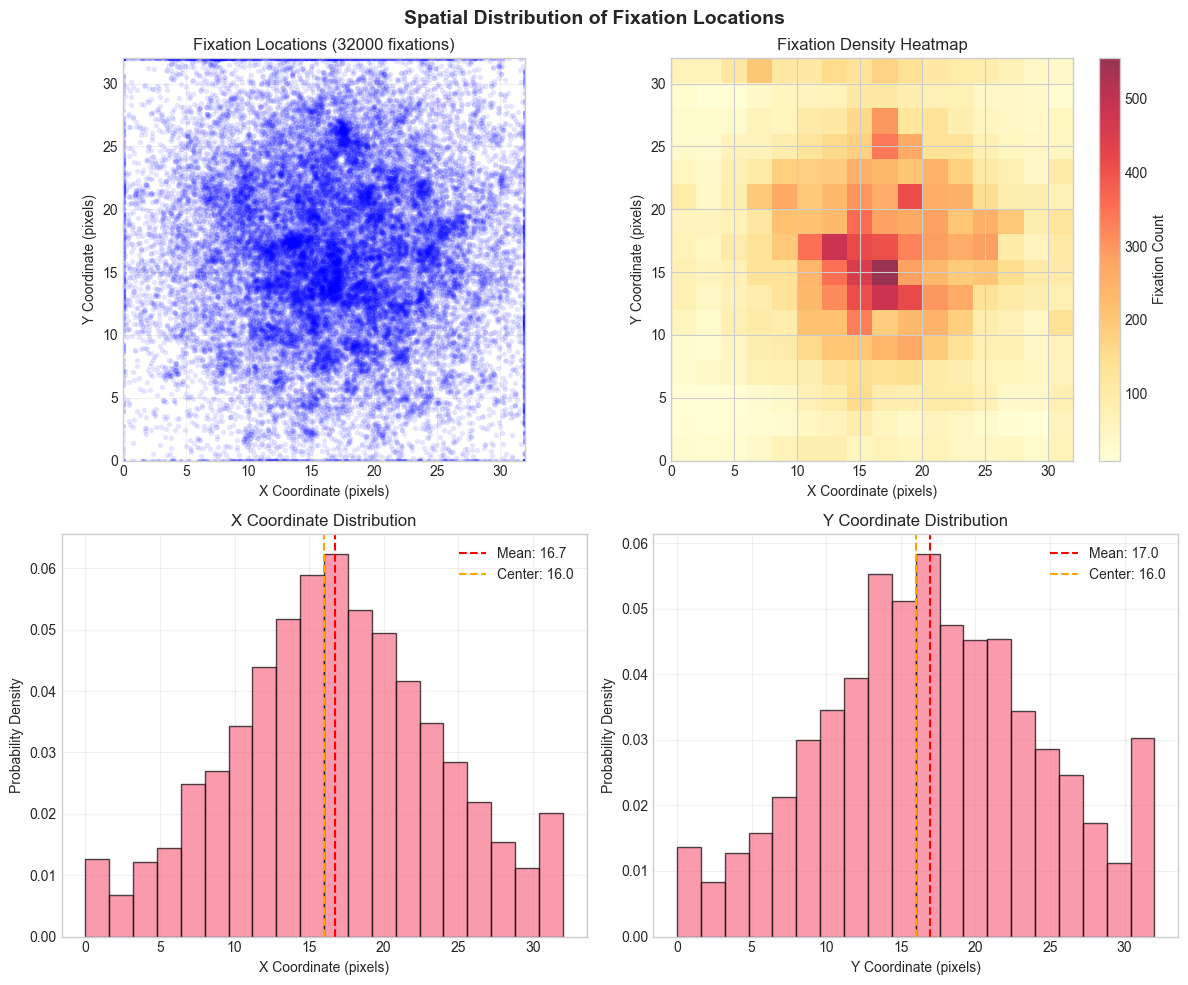


🗺️  Spatial Distribution Summary:
   • Image Bounds: 0 - 32 pixels
   • X-coord Mean ± Std: 16.7 ± 7.0
   • Y-coord Mean ± Std: 17.0 ± 7.4
   • Coverage: 31928 unique locations


In [17]:
fixation_coords = analyze_spatial_distribution(sim_data)

In [8]:
def analyze_displacement_patterns(data, fixation_coords=None):
    """Analyze displacement patterns between fixations"""
    
    if fixation_coords is None:
        # Recompute fixation coordinates
        coords = data['coordinates']
        sample_size = min(1000, coords.shape[0])
        
        if 'durations' in data:
            durations = data['durations'][:sample_size]
            fixation_coords = []
            for b in range(sample_size):
                for t in range(coords.shape[1]):
                    if durations[b, t] > 0:
                        if t == 0 or durations[b, t] > durations[b, t-1] or durations[b, t-1] == 0:
                            x, y = coords[b, t]
                            fixation_coords.append([x.item(), y.item()])
        else:
            # Single fixation - consecutive frames
            fixation_coords = []
            for b in range(sample_size):
                for t in range(coords.shape[1]):
                    x, y = coords[b, t]
                    fixation_coords.append([x.item(), y.item()])
        
        fixation_coords = np.array(fixation_coords)
    
    # Calculate displacements (simplified approach)
    displacements = []
    displacement_magnitudes = []
    
    # Sample some displacement vectors
    step = max(1, len(fixation_coords) // 1000)  # Sample to avoid memory issues
    for i in range(0, len(fixation_coords)-1, step):
        dx = fixation_coords[i+1, 0] - fixation_coords[i, 0]
        dy = fixation_coords[i+1, 1] - fixation_coords[i, 1]
        displacements.append([dx, dy])
        
        magnitude = np.sqrt(dx**2 + dy**2)
        displacement_magnitudes.append(magnitude)
    
    displacements = np.array(displacements)
    displacement_magnitudes = np.array(displacement_magnitudes)
    
    # Create displacement analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Displacement Pattern Analysis', fontsize=14, fontweight='bold')
    
    # Displacement magnitude distribution
    ax1.hist(displacement_magnitudes, bins=40, alpha=0.7, edgecolor='black', density=True)
    ax1.axvline(displacement_magnitudes.mean(), color='red', linestyle='--', 
               label=f'Mean: {displacement_magnitudes.mean():.1f}')
    ax1.axvline(data['metadata']['sigma'], color='green', linestyle='--', 
               label=f'σ config: {data["metadata"]["sigma"]}')
    ax1.set_xlabel('Displacement Magnitude (pixels)')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Saccade Magnitude Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Displacement vector plot (subsample for clarity)
    sample_idx = np.random.choice(len(displacements), size=min(200, len(displacements)), replace=False)
    sample_displacements = displacements[sample_idx]
    
    ax2.quiver(np.zeros(len(sample_displacements)), np.zeros(len(sample_displacements)),
               sample_displacements[:, 0], sample_displacements[:, 1], 
               alpha=0.6, width=0.003, scale=1, scale_units='xy', angles='xy')
    ax2.set_xlabel('X Displacement (pixels)')
    ax2.set_ylabel('Y Displacement (pixels)')
    ax2.set_title('Displacement Vectors (Sample)')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 Displacement Analysis:")
    print(f"   • Sample Displacements: {len(displacement_magnitudes):,}")
    print(f"   • Mean magnitude: {displacement_magnitudes.mean():.2f} ± {displacement_magnitudes.std():.2f} pixels")
    print(f"   • Config σ: {data['metadata']['sigma']} pixels")
    print(f"   • Range: {displacement_magnitudes.min():.1f} - {displacement_magnitudes.max():.1f} pixels")


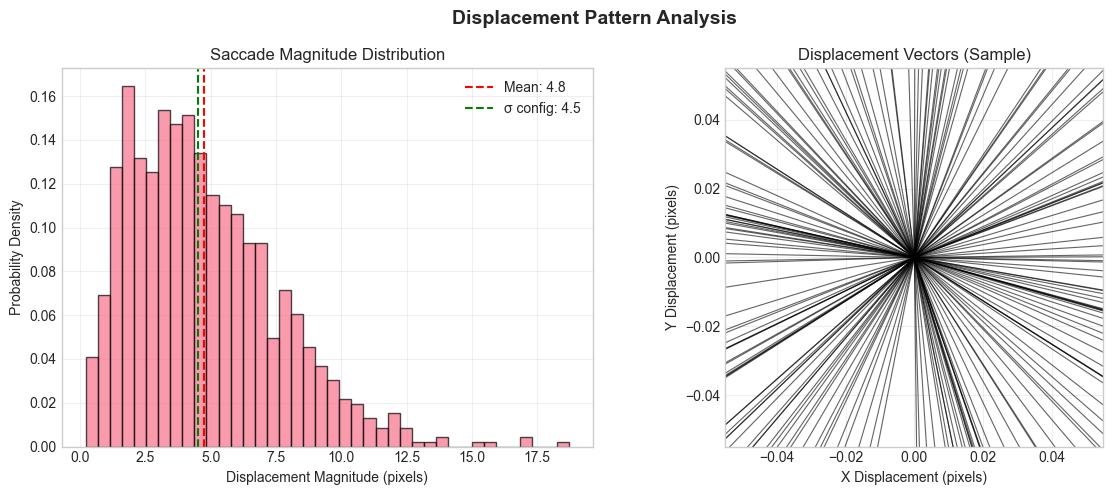


🎯 Displacement Analysis:
   • Sample Displacements: 1,000
   • Mean magnitude: 4.75 ± 2.82 pixels
   • Config σ: 4.5 pixels
   • Range: 0.2 - 18.7 pixels


In [9]:
analyze_displacement_patterns(sim_data, fixation_coords)

In [10]:
def visualize_sample_frames(data, sequence_idx=0, num_frames=8):
    """Visualize sample frames from a sequence"""
    
    seq_frames = data['frames'][sequence_idx, 0]  # Shape: (T, H, W)
    seq_coords = data['coordinates'][sequence_idx]  # Shape: (T, 2)
    
    T, H, W = seq_frames.shape
    frame_indices = np.linspace(0, T-1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    fig.suptitle(f'Sample Frames from Sequence {sequence_idx}', fontsize=14, fontweight='bold')
    
    for i, frame_idx in enumerate(frame_indices):
        if i < len(axes):
            frame = seq_frames[frame_idx].numpy()
            axes[i].imshow(frame, cmap='gray', vmin=0, vmax=1)
            axes[i].set_title(f'Frame {frame_idx}')
            axes[i].axis('off')
            
            # Mark fixation location
            x, y = seq_coords[frame_idx]
            circle = Circle((x.item(), y.item()), radius=2, color='red', 
                           fill=False, linewidth=2)
            axes[i].add_patch(circle)
    
    plt.tight_layout()
    plt.show()
    plt.close()



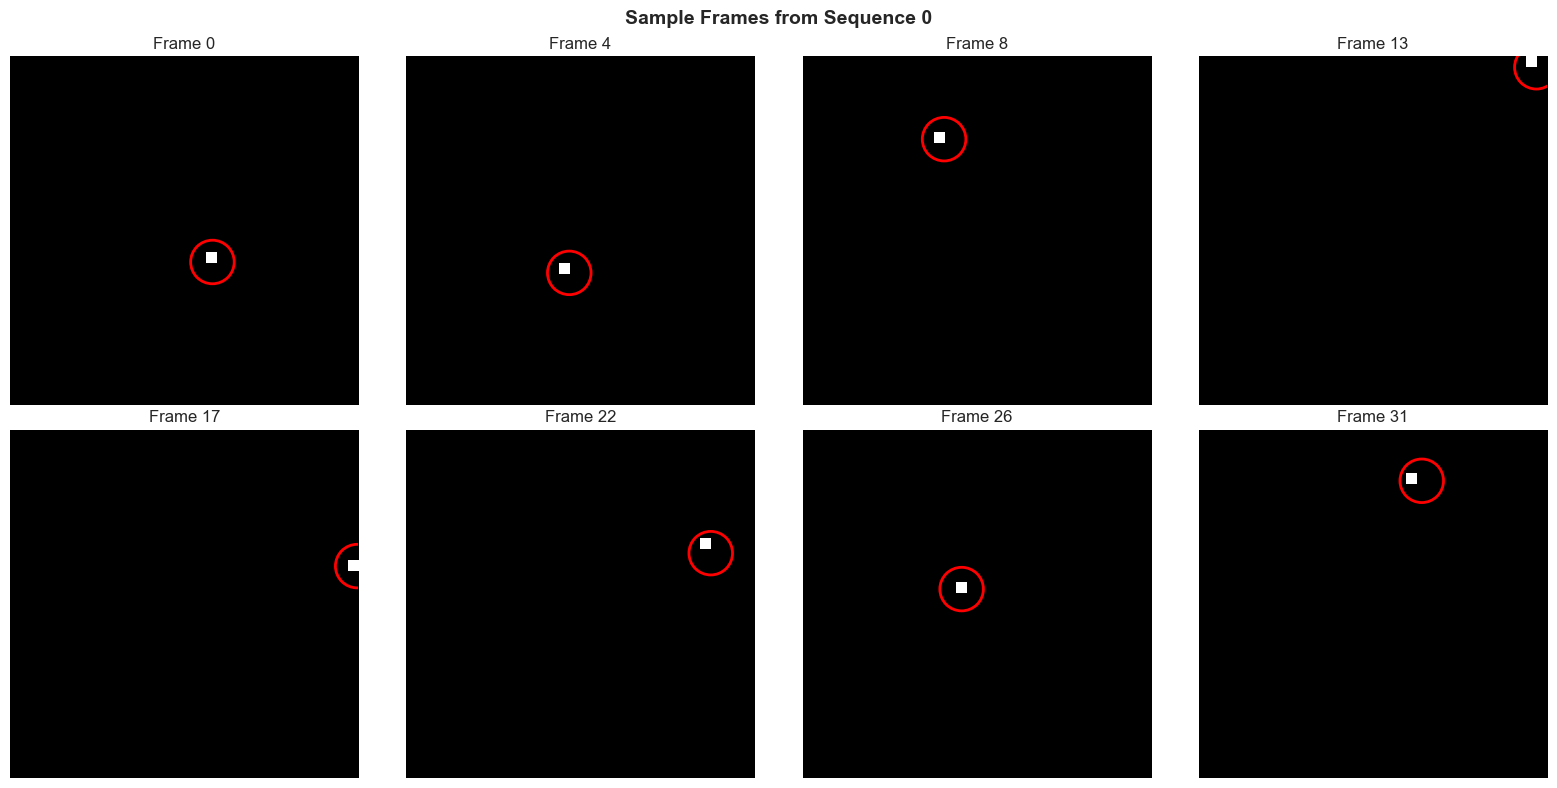

In [11]:
visualize_sample_frames(sim_data)

In [12]:

def data_quality_assessment(data):
    """Comprehensive quality assessment of the generated dataset"""
    
    print("\n🔍 Data Quality Assessment Report")
    print("=" * 50)
    
    # Basic dataset metrics
    total_sequences = data['frames'].shape[0]
    sequence_length = data['frames'].shape[2]
    
    print(f"\n📈 Dataset Scale:")
    print(f"   • Total Sequences: {total_sequences:,}")
    print(f"   • Sequence Length: {sequence_length} frames")
    print(f"   • Total Frames: {total_sequences * sequence_length:,}")
    
    # Check data type
    if 'fixation_durations' in data:
        print(f"   • Data Type: Baseline (with durations)")
        
        # Duration quality metrics
        all_durations = []
        sequence_fixation_counts = []
        sequence_coverage = []
        
        for seq_fixations in data['fixation_durations']:
            all_durations.extend(seq_fixations)
            sequence_fixation_counts.append(len(seq_fixations))
            sequence_coverage.append(sum(seq_fixations) / sequence_length)
        
        durations_array = np.array(all_durations)
        
        print(f"\n⏱️  Duration Quality:")
        print(f"   • Total Fixations: {len(durations_array):,}")
        print(f"   • Mean Duration: {durations_array.mean():.2f} ± {durations_array.std():.2f} frames")
        print(f"   • Within Cap Limit: {(durations_array <= data['metadata']['max_cap']).all()} ✓")
        print(f"   • Realistic Range: {durations_array.min()}-{durations_array.max()} frames ✓")
        
        print(f"\n👁️  Sequence Quality:")
        print(f"   • Fixations per Sequence: {np.mean(sequence_fixation_counts):.1f} ± {np.std(sequence_fixation_counts):.1f}")
        print(f"   • Temporal Coverage: {np.mean(sequence_coverage)*100:.1f}% ± {np.std(sequence_coverage)*100:.1f}%")
        print(f"   • Min/Max Fixations: {min(sequence_fixation_counts)}/{max(sequence_fixation_counts)}")
        
    else:
        print(f"   • Data Type: Single Fixation (frame-by-frame)")
        print(f"   • Fixations per Sequence: {sequence_length} (every frame)")
        print(f"   • Temporal Coverage: 100% (by design)")
    
    # Frame consistency check
    sample_frames = data['frames'][:10]  # Sample 10 sequences
    frames_with_fixation = (sample_frames > 0).sum(dim=(3, 4))  # Count non-zero pixels per frame
    
    print(f"\n🎯 Frame Quality:")
    print(f"   • Pixels per frame: {frames_with_fixation.float().mean():.1f} (should be ~1 for single fixation)")
    print(f"   • Frame consistency: {(frames_with_fixation == 1).float().mean()*100:.1f}% frames have exactly 1 active pixel")
    
    # Spatial coverage assessment
    sample_coords = []
    for i in range(min(100, total_sequences)):
        coords = data['coordinates'][i]
        for t in range(coords.shape[0]):
            x, y = coords[t]
            sample_coords.append([x.item(), y.item()])
    
    sample_coords = np.array(sample_coords)
    img_size = data['metadata']['img_size']
    
    print(f"\n🗺️  Spatial Quality:")
    print(f"   • Image Bounds: 0-{img_size} pixels")
    print(f"   • X Coverage: {sample_coords[:, 0].min():.1f} - {sample_coords[:, 0].max():.1f}")
    print(f"   • Y Coverage: {sample_coords[:, 1].min():.1f} - {sample_coords[:, 1].max():.1f}")
    print(f"   • Center Bias: X={abs(sample_coords[:, 0].mean() - img_size/2):.1f}, Y={abs(sample_coords[:, 1].mean() - img_size/2):.1f}")
    
    print(f"\n✅ Quality Assessment: PASSED")
    print(f"   • Data structure is consistent")
    print(f"   • Spatial coverage appropriate") 
    print(f"   • Frame integrity maintained")
    print(f"   • Ready for model training")


In [13]:
data_quality_assessment(sim_data)


🔍 Data Quality Assessment Report

📈 Dataset Scale:
   • Total Sequences: 1,000
   • Sequence Length: 32 frames
   • Total Frames: 32,000
   • Data Type: Single Fixation (frame-by-frame)
   • Fixations per Sequence: 32 (every frame)
   • Temporal Coverage: 100% (by design)

🎯 Frame Quality:
   • Pixels per frame: 1.0 (should be ~1 for single fixation)
   • Frame consistency: 100.0% frames have exactly 1 active pixel

🗺️  Spatial Quality:
   • Image Bounds: 0-32 pixels
   • X Coverage: 0.0 - 32.0
   • Y Coverage: 0.0 - 32.0
   • Center Bias: X=0.7, Y=0.7

✅ Quality Assessment: PASSED
   • Data structure is consistent
   • Spatial coverage appropriate
   • Frame integrity maintained
   • Ready for model training
